In [18]:
import numpy as np

class Counter(dict):
    def __init__(self, include_zeros = False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.top_three_list = []
        self.include_zeros = include_zeros
    
    def increment(self, item, delta = 1):
        new_val = delta + self.pop(item, 0)
        if new_val > 0:
            self[item] = new_val
        if self.include_zeros:
            self.update_top_three(item, new_val)
        else:
            self.update_top_three_no_zero(item, new_val)
    
    def update_top_three(self, item, value):
        counter = 0
        ## check if the key already exists in the top-three and update its value if it does
        for (k, v) in self.top_three_list:
            if item == k:
                counter += 1
                self.top_three_list.remove((k, v))
                self.top_three_list.append((k, value))
                self.top_three_list.sort(key=lambda x: x[1], reverse=True)
        ## check if there is space first [will always be space because we shorten list to three in final step], then check that the key does not already exist, and if so append it to the list
        if len(self.top_three_list) < 4:
            if counter == 0:
                self.top_three_list.append((item, value))
                self.top_three_list.sort(key=lambda x: x[1], reverse=True)
        ## take only top three of the elements of the list; and return only the values not the keys (i.e. the counts)
        self.top_three()

    def update_top_three_no_zero(self, item, value):
        if item != 0:
            counter = 0
            ## check if the key already exists in the top-three and update its value if it does
            for (k, v) in self.top_three_list:
                if item == k:
                    counter += 1
                    self.top_three_list.remove((k, v))
                    self.top_three_list.append((k, value))
                    self.top_three_list.sort(key=lambda x: x[1], reverse=True)
            ## check if there is space first [will always be space because we shorten list to three in final step], then check that the key does not already exist, and if so append it to the list
            if len(self.top_three_list) < 4:
                if counter == 0:
                    self.top_three_list.append((item, value))
                    self.top_three_list.sort(key=lambda x: x[1], reverse=True)
             ## take only top three of the elements of the list; and return only the values not the keys (i.e. the counts)
            self.top_three()

    def top_three(self):
        final_counts = []
        self.top_three_list = self.top_three_list[:3]
        for (k, v) in self.top_three_list:
            final_counts.append(v)
        return final_counts


def y(x):
    return 2**x

def find_tranformation_matrix(b, E, N, Tmax, stopping_crit = 0, zero_counts = False):

    M = np.shape(E)[0]
    ## find the number of events that occur in the interval from T = 0 to T = Tmax
    n = np.random.poisson(lam = Tmax*(N+b*M))

    ## find times for all events
    times = np.sort(np.random.uniform(0, Tmax, n))
    R = np.zeros(n, dtype = int)

    ##making a spatial plot
    spatial1 = np.zeros(n, dtype = int)
    spatial2 = np.zeros(n, dtype = int)
    spatial3 = np.zeros(n, dtype = int)
    
    X = [2**i for i in range(N)][::-1]

    ## default is to not include zero counts in the top three, set zero_counts = True in function call to include zero counts
    counts = Counter(include_zeros = zero_counts)
    for element in X:
        counts.increment(element, 1)

    # run simulation
    for t in range(n):
        
        if np.random.random() < N/(N + b*M):

            i = np.random.randint(N)

            if X[i] != 0:
                
                counts.increment(X[i], -1)

                X[i] = 0

                counts.increment(0, 1)
        else:

            i,j = E[np.random.randint(M)]

            if (X[i] != 0 or X[j] != 0) and X[i] != X[j]:
                    
                new = X[i] | X[j]
                counts.increment(X[i], -1)
                counts.increment(X[j], -1)
                counts.increment(new, 2)
                X[i] = X[j] = new
                
        R[t] = non_zero_distinct_rows = len(counts) - (0 in counts)
        
        ## making a spatial plot
        top_three = counts.top_three()
        if len(top_three) == 3:
            spatial1[t] = top_three[0]
            spatial2[t] = top_three[1]
            spatial3[t] = top_three[2]
        elif len(top_three) == 2:
            spatial1[t] = top_three[0]
            spatial2[t] = top_three[1]
            spatial3[t] = 0
        elif len(top_three) == 1:
            spatial1[t] = top_three[0]
            spatial2[t] = 0
            spatial3[t] = 0
        elif len(top_three) == 0:
            spatial1[t] = 0
            spatial2[t] = 0
            spatial3[t] = 0
        
        ## break the simulation because the pseudo mixing time has been found (the number of distinct rows and thus distinct columns is 2 or extinction, depending)

        if non_zero_distinct_rows == stopping_crit:
            times = times[:t+1]
            R = R[:t+1]
            spatial1 = spatial1[:t+1]
            spatial2 = spatial2[:t+1]
            spatial3 = spatial3[:t+1]
            break

    return times, R, spatial1, spatial2, spatial3


In [20]:
N =  4000
M = 3*N
Tmax = 500

## random edge matrix
E = np.random.randint(0,N,size=2*M).reshape((N*3, 2))

In [3]:
b = np.linspace(0.002, 0.5, 10)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = []
    maxs2 = []
    maxs3 = []
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1.append(spatial1[max_s1])
        max_s2 = np.argmax(spatial2)
        maxs2.append(spatial2[max_s2])
        max_s3 = np.argmax(spatial3)
        maxs3.append(spatial3[max_s3])
    print(maxs1)
    s1.append(maxs1)
    s2.append(maxs2)
    s3.append(maxs3)

print(s1)
print(s2)
print(s3)


[2, 2, 2, 2, 2]
[8, 6, 9, 6, 7]
[19, 11, 11, 13, 14]
[70, 43, 203, 69, 112]
[1090, 1078, 1044, 1078, 1093]
[1598, 1596, 1637, 1608, 1634]
[1979, 1994, 1983, 1969, 1991]
[2262, 2251, 2266, 2263, 2246]
[2467, 2478, 2463, 2474, 2469]
[2627, 2635, 2634, 2658, 2633]
[[2, 2, 2, 2, 2], [8, 6, 9, 6, 7], [19, 11, 11, 13, 14], [70, 43, 203, 69, 112], [1090, 1078, 1044, 1078, 1093], [1598, 1596, 1637, 1608, 1634], [1979, 1994, 1983, 1969, 1991], [2262, 2251, 2266, 2263, 2246], [2467, 2478, 2463, 2474, 2469], [2627, 2635, 2634, 2658, 2633]]
[[2, 2, 2, 2, 2], [6, 5, 5, 5, 6], [13, 9, 9, 9, 12], [36, 31, 20, 44, 59], [369, 172, 167, 308, 354], [255, 101, 298, 406, 138], [882, 195, 233, 675, 723], [133, 587, 348, 143, 428], [628, 138, 441, 631, 357], [407, 1097, 1080, 230, 825]]
[[2, 2, 2, 2, 2], [4, 5, 5, 4, 4], [11, 7, 8, 8, 9], [26, 21, 17, 30, 26], [40, 111, 110, 38, 173], [140, 72, 57, 69, 54], [115, 148, 144, 87, 96], [86, 86, 108, 99, 383], [293, 93, 311, 232, 144], [230, 167, 201, 172, 128]]


In [4]:
b = np.linspace(0.6, 5, 7)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = []
    maxs2 = []
    maxs3 = []
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1.append(spatial1[max_s1])
        max_s2 = np.argmax(spatial2)
        maxs2.append(spatial2[max_s2])
        max_s3 = np.argmax(spatial3)
        maxs3.append(spatial3[max_s3])
    print(maxs1)
    s1.append(maxs1)
    s2.append(maxs2)
    s3.append(maxs3)

print(s1)
print(s2)
print(s3)


[2859, 2853, 2857, 2852, 2868]
[3518, 3489, 3490, 3494, 3490]
[3678, 3682, 3676, 3691, 3685]
[3769, 3773, 3773, 3776, 3778]
[3825, 3825, 3829, 3824, 3836]
[3860, 3863, 3861, 3863, 3861]
[3878, 3885, 3880, 3879, 3881]
[[2859, 2853, 2857, 2852, 2868], [3518, 3489, 3490, 3494, 3490], [3678, 3682, 3676, 3691, 3685], [3769, 3773, 3773, 3776, 3778], [3825, 3825, 3829, 3824, 3836], [3860, 3863, 3861, 3863, 3861], [3878, 3885, 3880, 3879, 3881]]
[[1187, 388, 672, 821, 1320], [1168, 1369, 486, 1658, 1133], [1766, 799, 1473, 665, 1789], [1493, 1654, 1250, 1833, 1838], [769, 1777, 1453, 1158, 1882], [1868, 1898, 1793, 1726, 380], [1844, 1195, 566, 1863, 1821]]
[[318, 185, 434, 105, 80], [308, 835, 449, 453, 567], [202, 717, 537, 465, 437], [978, 425, 745, 300, 258], [729, 653, 471, 723, 663], [216, 599, 801, 721, 197], [559, 826, 431, 678, 698]]


S1*, S2*, S3*

In [2]:
s1star = [[2, 2, 2, 2, 2], [8, 6, 9, 6, 7], [19, 11, 11, 13, 14], [70, 43, 203, 69, 112], [1090, 1078, 1044, 1078, 1093], [1598, 1596, 1637, 1608, 1634], [1979, 1994, 1983, 1969, 1991], [2262, 2251, 2266, 2263, 2246], [2467, 2478, 2463, 2474, 2469], [2627, 2635, 2634, 2658, 2633],[2859, 2853, 2857, 2852, 2868], [3518, 3489, 3490, 3494, 3490], [3678, 3682, 3676, 3691, 3685], [3769, 3773, 3773, 3776, 3778], [3825, 3825, 3829, 3824, 3836], [3860, 3863, 3861, 3863, 3861], [3878, 3885, 3880, 3879, 3881]]
s2star = [[2, 2, 2, 2, 2], [6, 5, 5, 5, 6], [13, 9, 9, 9, 12], [36, 31, 20, 44, 59], [369, 172, 167, 308, 354], [255, 101, 298, 406, 138], [882, 195, 233, 675, 723], [133, 587, 348, 143, 428], [628, 138, 441, 631, 357], [407, 1097, 1080, 230, 825], [1187, 388, 672, 821, 1320], [1168, 1369, 486, 1658, 1133], [1766, 799, 1473, 665, 1789], [1493, 1654, 1250, 1833, 1838], [769, 1777, 1453, 1158, 1882], [1868, 1898, 1793, 1726, 380], [1844, 1195, 566, 1863, 1821]]
s3star = [[2, 2, 2, 2, 2], [4, 5, 5, 4, 4], [11, 7, 8, 8, 9], [26, 21, 17, 30, 26], [40, 111, 110, 38, 173], [140, 72, 57, 69, 54], [115, 148, 144, 87, 96], [86, 86, 108, 99, 383], [293, 93, 311, 232, 144], [230, 167, 201, 172, 128], [318, 185, 434, 105, 80], [308, 835, 449, 453, 567], [202, 717, 537, 465, 437], [978, 425, 745, 300, 258], [729, 653, 471, 723, 663], [216, 599, 801, 721, 197], [559, 826, 431, 678, 698]]

In [5]:
b = np.linspace(0.002, 0.5, 10)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = []
    maxs2 = []
    maxs3 = []
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0, True)
        max_s1 = np.argmax(spatial1)
        maxs1.append(spatial1[max_s1])
        max_s2 = np.argmax(spatial2)
        maxs2.append(spatial2[max_s2])
        max_s3 = np.argmax(spatial3)
        maxs3.append(spatial3[max_s3])
    print(maxs1)
    s1.append(maxs1)
    s2.append(maxs2)
    s3.append(maxs3)

print(s1)
print(s2)
print(s3)


[4000, 4000, 4000, 4000, 4000]
[4000, 4000, 4000, 4000, 4000]
[4000, 4000, 4000, 4000, 4000]
[4000, 4000, 4000, 4000, 4000]
[3282, 3279, 3292, 3273, 3297]
[2726, 2717, 2727, 2752, 2741]
[2328, 2306, 2342, 2335, 2339]
[2274, 2261, 2255, 2267, 2249]
[2466, 2478, 2467, 2465, 2475]
[2634, 2659, 2636, 2617, 2634]
[[4000, 4000, 4000, 4000, 4000], [4000, 4000, 4000, 4000, 4000], [4000, 4000, 4000, 4000, 4000], [4000, 4000, 4000, 4000, 4000], [3282, 3279, 3292, 3273, 3297], [2726, 2717, 2727, 2752, 2741], [2328, 2306, 2342, 2335, 2339], [2274, 2261, 2255, 2267, 2249], [2466, 2478, 2467, 2465, 2475], [2634, 2659, 2636, 2617, 2634]]
[[2, 2, 3, 2, 2], [8, 7, 6, 7, 7], [12, 13, 18, 17, 12], [80, 45, 56, 124, 72], [1066, 1041, 1083, 1059, 1078], [1617, 1610, 1618, 1598, 1628], [1964, 2000, 2000, 1973, 1981], [2000, 2000, 2000, 2000, 2000], [1827, 1845, 1829, 1810, 1832], [1663, 1640, 1633, 1646, 1653]]
[[2, 2, 2, 2, 2], [6, 5, 5, 6, 5], [9, 10, 13, 12, 9], [37, 32, 36, 45, 45], [181, 137, 101, 110,

In [6]:
b = np.linspace(0.6, 5, 7)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = []
    maxs2 = []
    maxs3 = []
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0, True)
        max_s1 = np.argmax(spatial1)
        maxs1.append(spatial1[max_s1])
        max_s2 = np.argmax(spatial2)
        maxs2.append(spatial2[max_s2])
        max_s3 = np.argmax(spatial3)
        maxs3.append(spatial3[max_s3])
    print(maxs1)
    s1.append(maxs1)
    s2.append(maxs2)
    s3.append(maxs3)

print(s1)
print(s2)
print(s3)


[2861, 2876, 2859, 2853, 2842]
[3509, 3498, 3497, 3485, 3490]
[3680, 3679, 3680, 3690, 3683]
[3767, 3773, 3772, 3783, 3771]
[3824, 3825, 3824, 3828, 3822]
[3859, 3855, 3861, 3858, 3857]
[3878, 3877, 3884, 3884, 3880]
[[2861, 2876, 2859, 2853, 2842], [3509, 3498, 3497, 3485, 3490], [3680, 3679, 3680, 3690, 3683], [3767, 3773, 3772, 3783, 3771], [3824, 3825, 3824, 3828, 3822], [3859, 3855, 3861, 3858, 3857], [3878, 3877, 3884, 3884, 3880]]
[[1419, 1411, 1411, 1392, 1442], [707, 1656, 707, 1207, 1386], [1790, 1803, 1749, 486, 1163], [1777, 1074, 371, 868, 1619], [1835, 1392, 1634, 1748, 1394], [1793, 1417, 1899, 1397, 1537], [1219, 1613, 1921, 738, 1871]]
[[921, 419, 1005, 1121, 1301], [652, 688, 441, 662, 622], [444, 416, 455, 264, 525], [532, 638, 310, 694, 931], [289, 923, 512, 349, 368], [486, 1012, 760, 564, 932], [850, 907, 446, 688, 366]]


In [26]:
s1 = [[4000, 4000, 4000, 4000, 4000], [4000, 4000, 4000, 4000, 4000], [4000, 4000, 4000, 4000, 4000], [4000, 4000, 4000, 4000, 4000], [3282, 3279, 3292, 3273, 3297], [2726, 2717, 2727, 2752, 2741], [2328, 2306, 2342, 2335, 2339], [2274, 2261, 2255, 2267, 2249], [2466, 2478, 2467, 2465, 2475], [2634, 2659, 2636, 2617, 2634], [2861, 2876, 2859, 2853, 2842], [3509, 3498, 3497, 3485, 3490], [3680, 3679, 3680, 3690, 3683], [3767, 3773, 3772, 3783, 3771], [3824, 3825, 3824, 3828, 3822], [3859, 3855, 3861, 3858, 3857], [3878, 3877, 3884, 3884, 3880]]
s2 = [[2, 2, 3, 2, 2], [8, 7, 6, 7, 7], [12, 13, 18, 17, 12], [80, 45, 56, 124, 72], [1066, 1041, 1083, 1059, 1078], [1617, 1610, 1618, 1598, 1628], [1964, 2000, 2000, 1973, 1981], [2000, 2000, 2000, 2000, 2000], [1827, 1845, 1829, 1810, 1832], [1663, 1640, 1633, 1646, 1653], [1419, 1411, 1411, 1392, 1442], [707, 1656, 707, 1207, 1386], [1790, 1803, 1749, 486, 1163], [1777, 1074, 371, 868, 1619], [1835, 1392, 1634, 1748, 1394], [1793, 1417, 1899, 1397, 1537], [1219, 1613, 1921, 738, 1871]]
s3 = [[2, 2, 2, 2, 2], [6, 5, 5, 6, 5], [9, 10, 13, 12, 9], [37, 32, 36, 45, 45], [181, 137, 101, 110, 76], [204, 384, 344, 152, 728], [309, 120, 536, 156, 409], [988, 868, 995, 228, 513], [657, 1159, 120, 733, 279], [804, 1237, 151, 346, 225], [921, 419, 1005, 1121, 1301], [652, 688, 441, 662, 622], [444, 416, 455, 264, 525], [532, 638, 310, 694, 931], [289, 923, 512, 349, 368], [486, 1012, 760, 564, 932], [850, 907, 446, 688, 366]]
b = [0.002, 0.05733333333333333, 0.11266666666666666, 0.16799999999999998, 0.22333333333333333, 0.2786666666666667, 0.33399999999999996, 0.3893333333333333, 0.44466666666666665, 0.5, 0.6, 1.3333333333333335, 2.066666666666667, 2.8000000000000003, 3.5333333333333337, 4.266666666666667, 5.0]

In [27]:
import numpy as np
s1starvar = [np.var(s1star[i]) for i in range(len(s1star))]
s1staravg = [np.mean(s1star[i]) for i in range(len(s1star))]

s2starvar = [np.var(s2star[i]) for i in range(len(s2star))]
s2staravg = [np.mean(s2star[i]) for i in range(len(s2star))]

s3starvar = [np.var(s3star[i]) for i in range(len(s3star))]
s3staravg = [np.mean(s3star[i]) for i in range(len(s3star))]

s1var = [np.var(s1[i]) for i in range(len(s1))]
s1avg = [np.mean(s1[i]) for i in range(len(s1))]

s2var = [np.var(s2[i]) for i in range(len(s2))]
s2avg = [np.mean(s2[i]) for i in range(len(s2))]

s3var = [np.var(s3[i]) for i in range(len(s3))]
s3avg = [np.mean(s3[i]) for i in range(len(s3))]


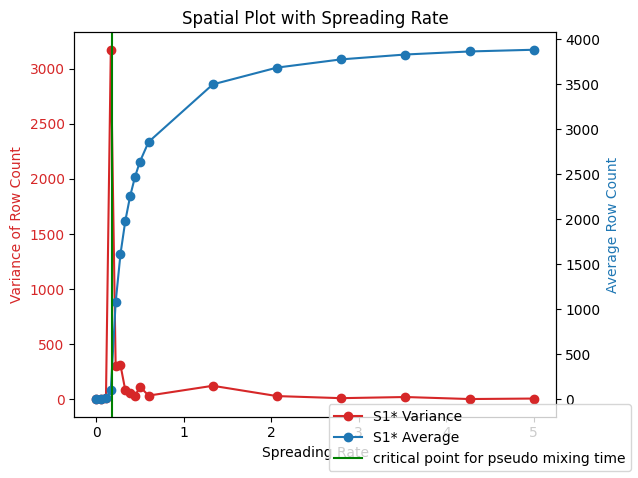

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s1starvar, color=color, marker = 'o', label= 'S1* Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s1staravg, color=color, marker = 'o', label= 'S1* Average')
ax2.set_ylabel('Average Row Count', color=color)
plt.axvline(x=0.17985714, color='g', label = 'critical point for pseudo mixing time')


fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


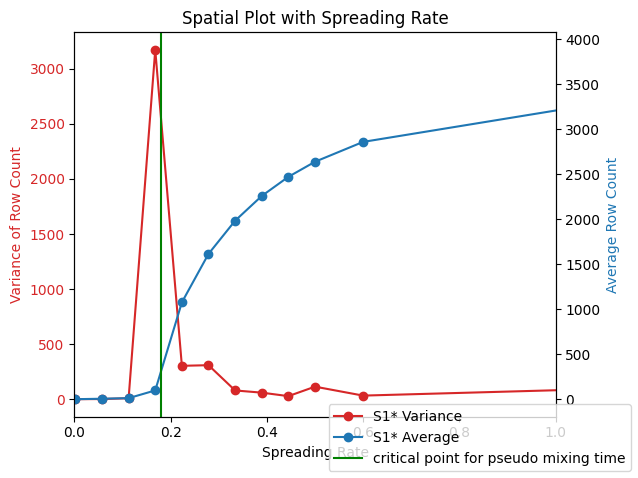

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s1starvar, color=color, marker = 'o', label= 'S1* Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s1staravg, color=color, marker = 'o', label= 'S1* Average')
ax2.set_ylabel('Average Row Count', color=color)
plt.axvline(x=0.17985714, color='g', label = 'critical point for pseudo mixing time')
plt.xlim(0, 1)

fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


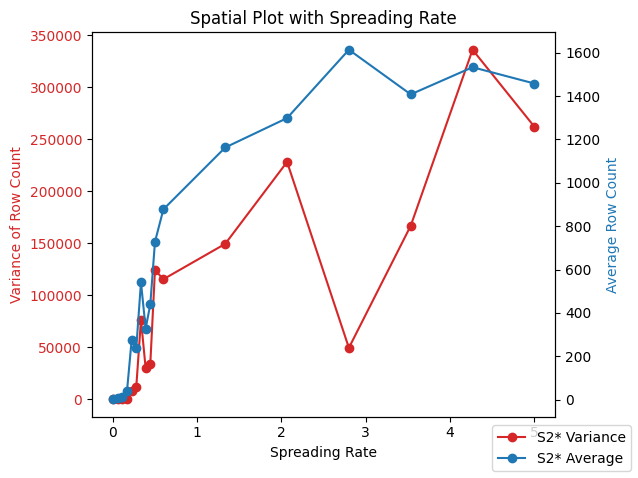

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s2starvar, color=color, marker = 'o', label= 'S2* Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s2staravg, color=color, marker = 'o', label= 'S2* Average')
ax2.set_ylabel('Average Row Count', color=color)
fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
 

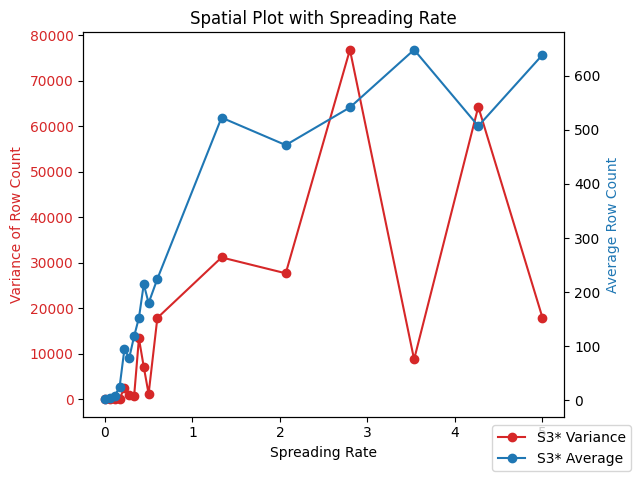

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s3starvar, color=color, marker = 'o', label= 'S3* Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s3staravg, color=color, marker = 'o', label= 'S3* Average')
ax2.set_ylabel('Average Row Count', color=color)
fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


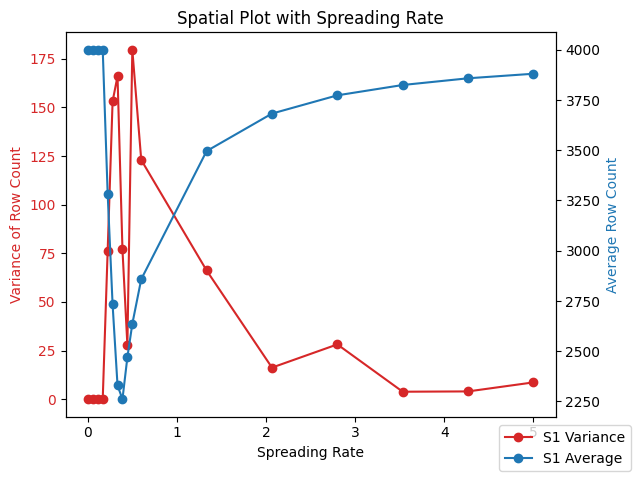

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s1var, color=color, marker = 'o', label= 'S1 Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s1avg, color=color, marker = 'o', label= 'S1 Average')
ax2.set_ylabel('Average Row Count', color=color)
fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


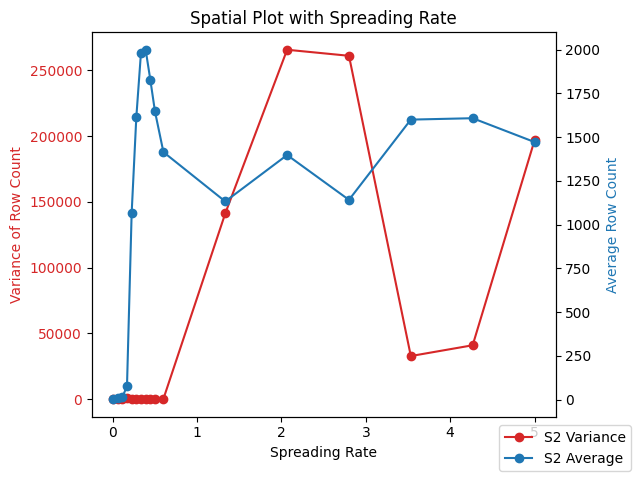

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s2var, color=color, marker = 'o', label= 'S2 Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s2avg, color=color, marker = 'o', label= 'S2 Average')
ax2.set_ylabel('Average Row Count', color=color)
fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


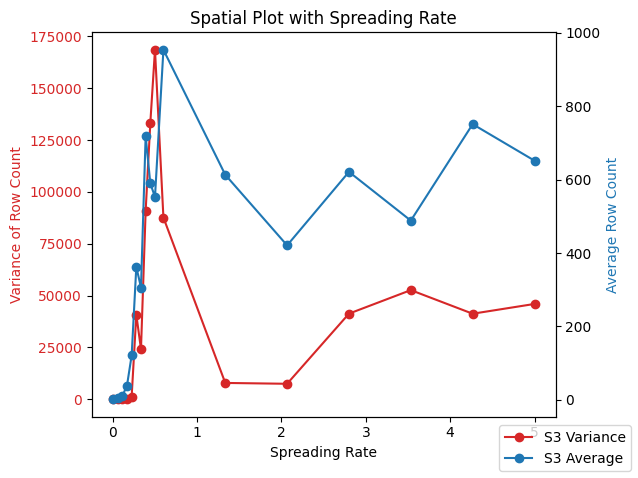

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s3var, color=color, marker = 'o', label= 'S3 Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s3avg, color=color, marker = 'o', label= 'S3 Average')
ax2.set_ylabel('Average Row Count', color=color)
fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [21]:
b = np.linspace(0.002, 0.5, 15)

p_mixing_times = []

for i in range(len(b)):
    t_p_mixing = 0
    for j in range(10):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 1)
        p_mix_index = np.min(np.where(R==1)[0])
        t_p_mixing += times[p_mix_index]
    p_mixing_times.append(t_p_mixing/10)
    print(t_p_mixing/10)

print(p_mixing_times)


7.5001264357593245
10.287249410043465
12.568358329792762
17.233346721385878
30.640760216417476
132.19376679184808
64.45343760510903
41.832414280544974
33.32958847155352
27.54992461444071
24.59614929785954
20.297358918590884
18.31696352302123
16.21843879672374
15.16312112781485
[7.5001264357593245, 10.287249410043465, 12.568358329792762, 17.233346721385878, 30.640760216417476, 132.19376679184808, 64.45343760510903, 41.832414280544974, 33.32958847155352, 27.54992461444071, 24.59614929785954, 20.297358918590884, 18.31696352302123, 16.21843879672374, 15.16312112781485]


In [24]:
btimes = np.linspace(0.002, 0.5, 15)
ptimes = [7.5001264357593245, 10.287249410043465, 12.568358329792762, 17.233346721385878, 30.640760216417476, 132.19376679184808, 64.45343760510903, 41.832414280544974, 33.32958847155352, 27.54992461444071, 24.59614929785954, 20.297358918590884, 18.31696352302123, 16.21843879672374, 15.16312112781485]
print(btimes)

[0.002      0.03757143 0.07314286 0.10871429 0.14428571 0.17985714
 0.21542857 0.251      0.28657143 0.32214286 0.35771429 0.39328571
 0.42885714 0.46442857 0.5       ]


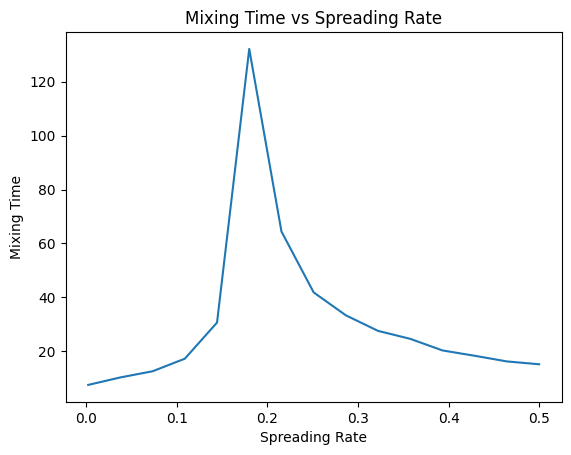

In [23]:
import matplotlib.pyplot as plt

plt.plot(btimes, ptimes)
plt.xlabel('Spreading Rate')
plt.ylabel('Mixing Time')
plt.title('Mixing Time vs Spreading Rate')
plt.show()
